In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [ ]:
from pathlib import Path
from pprint import pprint
from PIL import Image
from onnxruntime import InferenceSession
from typing import Union, Collection, Optional, List
from collections import defaultdict
from tqdm.auto import tqdm

import mimetypes
import os
import torchvision.transforms as Tfms
import PIL
import torch
import numpy as np
import pandas as pd
import json

### Preprocessing Utils

In [ ]:
def to_numpy(x:torch.Tensor):
    if x.requires_grad: return x.detach().cpu().numpy()
    else:               return x.cpu().numpy()
    
open_image = lambda x: PIL.Image.open(x).convert('RGB')

In [ ]:
inference_tfms = Tfms.Compose([
    Tfms.Resize(size=(224,224), interpolation=PIL.Image.BILINEAR),
    Tfms.ToTensor(),
    Tfms.Normalize(mean=(0.485, 0.456, 0.406),
                   std=(0.229, 0.224, 0.225))
])

In [ ]:
open_image = lambda f: PIL.Image.open(f).convert('RGB')

def preprocess_input(x:Union[str,Path,PIL.Image.Image],
                     tfms:Tfms.Compose = inference_tfms,
                     as_numpy:bool     = True):
    'Take a filename or (3,224,224) tensor and prep for model inference'
    # open as PIL image if input is a filename
    if isinstance(x, (str,Path)): x = open_image(x)
        
    # convert PIL image to 
    x = tfms(x).unsqueeze(0) # (3,224,224) -> (1,3,224,224)
    x = x.cuda() if torch.cuda.is_available() else x
    
    if as_numpy: return to_numpy(x)
    return x

### Load Model

In [ ]:
# INPUTS
model_path    = '/Users/rahulsomani/Desktop/Synopsis/beta/models_3-1-2/CinemaNet_3_1_2.onnx'
taxonomy_path = '/Users/rahulsomani/Desktop/Synopsis/beta/models_3-1-2/taxonomy_formatted.json'
shotdeck_path = '/Users/rahulsomani/Desktop/shotdeck-cropped/'
output_path   = '/Users/rahulsomani/Desktop/Synopsis/inference/video-tests/'

In [ ]:
session  = InferenceSession(model_path)
try:    session.set_providers(['CUDAExecutionProvider'])
except: session.set_providers(['CPUExecutionProvider'])
    
with open(taxonomy_path) as f: taxonomy = json.load(f)

In [ ]:
def predict(inp:Union[str,Path,PIL.Image.Image],
            category:Union[str,List[str],None] = 'shot_framing', 
            taxonomy:dict = taxonomy):
    
    x = {session.get_inputs()[0].name: preprocess_input(inp)} # {'input_image': x (1,3,224,224)}
    
    if isinstance(category,str):
          preds = session.run([category], x)
    else: preds = session.run(category, x)
        
    preds = preds[0].flatten()
    preds = {
        label:f"{pred:.6f}" for (_,label),pred in zip(
        taxonomy[category].items(), preds
    )}
    return preds



def predict(inp:Union[str,Path,PIL.Image.Image],
            categories:Union[str,List[str],None] = 'shot_framing', 
            taxonomy:dict = taxonomy):

    if isinstance(categories,str):  categories = [categories]
    if isinstance(categories,type(None)): categories = list(taxonomy.keys())
    
    x = {session.get_inputs()[0].name: preprocess_input(inp)} # {'input_image': x (1,3,224,224)}
    
    preds = session.run(categories, x)
    preds = [p[0].flatten() for p in preds]
    
    assert len(categories) == len(preds)
    
    preds_pretty = defaultdict()

    for category, predictions in zip(categories, preds):
        preds_pretty[category] = {
            label:float(f"{pred:.4f}") for (_,label),pred in zip(
            taxonomy[category].items(), predictions
        )}

    return dict(preds_pretty)

In [ ]:
from fastai.vision.data import get_image_files
files = get_image_files(Path(shotdeck_path)/'A', recurse=False)

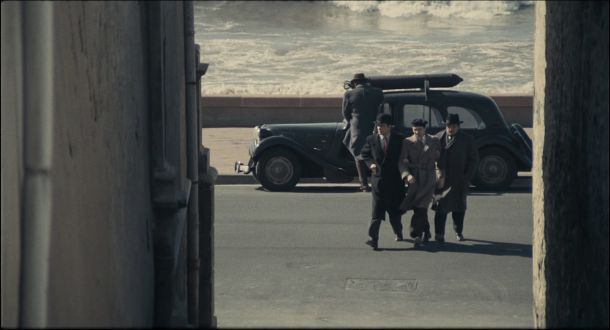

In [ ]:
f = np.random.choice(files)
open_image(f)

preds = predict(f, None)
#pprint(preds)

In [ ]:
preds['shot_angle']

{'shot.angle.overhead': 0.0005,
 'shot.angle.aerial': 0.0004,
 'shot.angle.high': 0.0894,
 'shot.angle.level': 0.8987,
 'shot.angle.low': 0.0109,
 'shot.angle.na': 0.0001}

In [ ]:
def get_top_k(preds_dict:dict, top_k:int=3):
    'Return top-k values of an input prediction dictionary in decreasing order of confidence'
    # extract dict keys and values
    keys,vals = zip(*preds_dict.items())
    keys,vals = np.array(keys), np.array(vals)
    
    # get sorted top_k indexes
    top_k_idxs = (-vals).argsort()[:top_k]
    
    # get top_k keys and values
    keys = keys[top_k_idxs]
    vals = vals[top_k_idxs]
    
    return {k:v for k,v in zip(keys,vals)}
    
# Example
get_top_k(top_k=2, preds_dict = {
    'Medium':   0.15,
    'Long':     0.80,
    'Close Up': 0.05
})

{'Long': 0.8, 'Medium': 0.15}

In [ ]:
def format_preds(preds_dict:dict, label_formatting_dict:dict=None, conf_level:bool=True, top_k:int=1):
    '''
    `preds_dict`: dictionary of preds where the keys are the labels
                  and the values the confidence levels (floats)
    `conf_level`: print confidence level or not
    `label_formatting_dict`: a dictionary that maps the keys of `preds_dict`
                             to a user readable format
    '''
    
    def format_label(label:str, formatter=label_formatting_dict):
        try:    return label_formatting_dict[label]
        except: return label
    
    preds_dict = get_top_k(preds_dict, top_k)
    
    result = []
    for label,conf in preds_dict.items():
        label = format_label(label)
        if conf_level: result.append(f"{label}: {conf*100:.02f} %")
        #if conf_level: result.append(f"{label}: {conf:.04f}")
        else:          result.append(label)
        
    return result

#[format_preds(preds[cat]) for cat in preds.keys()]



# Example
format_preds(
    preds_dict = {
        'medium.shot':      0.5,
        'medium.long.shot': 0.3,
        'long.shot':        0.2
    },
    label_formatting_dict = {
        'medium.shot':      'Medium',
        'medium.long.shot': 'Medium Long',
        'long.shot':        'Long'
    },
    conf_level=True,
    top_k=3
)

['Medium: 50.00 %', 'Medium Long: 30.00 %', 'Long: 20.00 %']

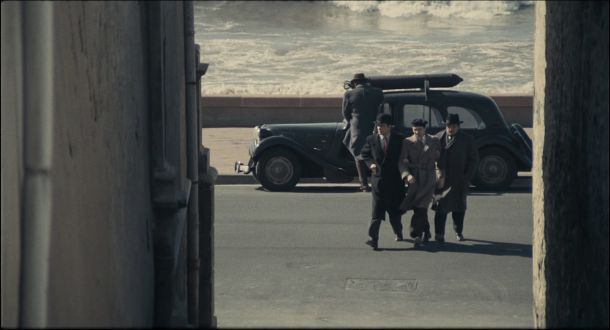

[['color.key.shot.na: 99.99 %', 'color.key.blue: 0.00 %'],
 ['color.saturation.neutral: 99.98 %', 'color.saturation.desaturated: 0.01 %'],
 ['color.theory.analagous: 96.09 %', 'color.theory.complementary: 3.41 %'],
 ['color.tones.cool: 85.06 %', 'color.tones.warm: 14.83 %'],
 ['shot.angle.level: 89.87 %', 'shot.angle.high: 8.94 %'],
 ['shot.composition.right: 70.42 %', 'shot.composition.balanced: 28.37 %'],
 ['shot.focus.deep: 98.48 %', 'shot.focus.out: 0.78 %'],
 ['shot.framing.wide: 62.13 %', 'shot.framing.long: 30.04 %'],
 ['shot.level.level: 99.81 %', 'shot.level.tilted: 0.17 %'],
 ['shot.lighting.cast.hard: 63.99 %', 'shot.lighting.cast.soft: 35.85 %'],
 ['shot.lighting.contrast.low: 90.16 %',
  'shot.lighting.contrast.high: 8.59 %'],
 ['shot.lighting.direction.back: 58.57 %',
  'shot.lighting.direction.top: 24.58 %'],
 ['shot.lighting.silhouette.not.silhouette: 83.65 %',
  'shot.lighting.silhouette.silhouette: 15.51 %'],
 ['shot.location.exterior: 89.94 %', 'shot.location.interio

In [ ]:
open_image(f)

preds = predict(f, None)
[format_preds(preds[cat], top_k=2) for cat in preds.keys()]

In [ ]:
[format_preds(preds[cat]) for cat in preds.keys()]

[['color.key.shot.na: 99.99 %'],
 ['color.saturation.neutral: 99.98 %'],
 ['color.theory.analagous: 96.09 %'],
 ['color.tones.cool: 85.06 %'],
 ['shot.angle.level: 89.87 %'],
 ['shot.composition.right: 70.42 %'],
 ['shot.focus.deep: 98.48 %'],
 ['shot.framing.wide: 62.13 %'],
 ['shot.level.level: 99.81 %'],
 ['shot.lighting.cast.hard: 63.99 %'],
 ['shot.lighting.contrast.low: 90.16 %'],
 ['shot.lighting.direction.back: 58.57 %'],
 ['shot.lighting.silhouette.not.silhouette: 83.65 %'],
 ['shot.location.exterior: 89.94 %'],
 ['shot.location.scene.exterior.structure.vehicle.motorcycle: 22.87 %'],
 ['shot.subject.vehicle: 50.80 %'],
 ['shot.timeofday.day: 99.87 %'],
 ['shot.type.group: 49.36 %'],
 ['shot.type.overtheshoulder.not.overtheshoulder: 94.50 %'],
 ['texture.potholed: 73.58 %']]

In [ ]:
format_preds(preds['shot_angle'], top_k=2)

['shot.angle.level: 89.87 %', 'shot.angle.high: 8.94 %']

### Image Draw Prep

In [ ]:
color = lambda r,g,b: f'rgb({r},{g},{b})'

from PIL import ImageDraw, ImageFont

def draw(img:PIL.Image.Image,
         labels:list,
         font_size:float=None,
         font_color:Union[tuple,int] = (220,220,220),
         font_path  = '../fonts/DIN Alternate Bold.ttf',
         location   = 'bottom',
         draw_rect  = False,
        ) -> PIL.Image.Image:
    draw = ImageDraw.Draw(img)
    if font_size is None: font_size = int(img.height/15)
    fcolor = color(*font_color)
    font   = ImageFont.truetype(font_path, size=font_size)
    
    if 'bottom' in location and draw_rect:
        draw.rectangle(xy=((0,img.height-(1.1*len(labels)*font_size*1.5)),
                           (img.width,img.height)),
                       fill='black')

    for i,label in enumerate(list(reversed(labels))):
        if 'bottom' in location:
            height = img.height-((i+1)*font_size*1.5)
        
        elif 'top' in location:
            height = img

In [ ]:
color = lambda r,g,b: f'rgb({r},{g},{b})'

from PIL import ImageDraw, ImageFont

def draw(img:PIL.Image.Image,
         labels:list,
         font_size:float=None,
         font_color:Union[tuple,int] = (220,220,220),
         font_path  = '../fonts/DIN Alternate Bold.ttf',
         location   = 'bottom',
         draw_rect  = False,
         width_factor = 40
        ) -> PIL.Image.Image:
    draw = ImageDraw.Draw(img)
    if font_size is None: font_size = int(img.width/width_factor)
    fcolor = color(*font_color)
    font   = ImageFont.truetype(font_path, size=font_size)
    
    if 'bottom' in location and draw_rect:
        draw.rectangle(xy=((0,img.height-(1.1*len(labels)*font_size*1.5)),
                           (img.width,img.height)),
                       fill='black')

    for i,label in enumerate(list(reversed(labels))):
        if 'bottom' in location or 'top' in location:
            w,h = draw.textsize(label, font)
            
        if 'bottom' in location:
            height = img.height-((i+1)*font_size*1.2)
        
        elif 'top' in location:
            height = img.height*0.01
        
        if location=='bottom' or location=='top': xy = ( (img.width - w)/2, height)
        elif '-right' in location: xy = ( ((img.width - (w+img.width*0.01))), height )
        elif '-left' in location:  xy = ( img.width*0.01 , height )
            
        
        else:
            if i==0: y=1
            else:    y=(i*font_size*1.5)
            xy = (10,y)

        # thin border
        x,y = xy[0],xy[1]
        draw.text((x-1, y), label, font=font, fill='black')
        draw.text((x+1, y), label, font=font, fill='black')
        draw.text((x, y-1), label, font=font, fill='black')
        draw.text((x, y+1), label, font=font, fill='black')

        # thicker border
        draw.text((x-1, y-1), label, font=font, fill='black')
        draw.text((x+1, y-1), label, font=font, fill='black')
        draw.text((x-1, y+1), label, font=font, fill='black')
        draw.text((x+1, y+1), label, font=font, fill='black')
        
        draw.text(xy, text=label, fill=fcolor, font=font)
    return img

In [ ]:
test_path = Path('/Users/rahulsomani/Downloads/AI Test - Sample Films/')
test_path.ls()

#files = get_image_files(test_path/'Amelie', recurse=True)
files = get_image_files(test_path, recurse=True)
files.sort()

[PosixPath('/Users/rahulsomani/Downloads/AI Test - Sample Films/Amelie'),
 PosixPath('/Users/rahulsomani/Downloads/AI Test - Sample Films/Safe'),
 PosixPath('/Users/rahulsomani/Downloads/AI Test - Sample Films/.DS_Store'),
 PosixPath('/Users/rahulsomani/Downloads/AI Test - Sample Films/Blade Runner 2049'),
 PosixPath('/Users/rahulsomani/Downloads/AI Test - Sample Films/The Neon Demon'),
 PosixPath('/Users/rahulsomani/Downloads/AI Test - Sample Films/Alien'),
 PosixPath('/Users/rahulsomani/Downloads/AI Test - Sample Films/Sunset Boulevard'),
 PosixPath('/Users/rahulsomani/Downloads/AI Test - Sample Films/The Revenant'),
 PosixPath('/Users/rahulsomani/Downloads/AI Test - Sample Films/Slumdog Millionaire')]

In [ ]:
from functools import partial

save_path = Path('/Users/rahulsomani/Dropbox/AI Test - Results')
save_path.mkdir(exist_ok=True)

for f in tqdm(files):
    preds = predict(f, None)
    img   = open_image(f)

    format_preds = partial(format_preds, label_formatting_dict=label_formatter)

    shot_preds = \
        format_preds(preds['shot_type'], top_k=1) +\
        format_preds(preds['shot_composition'], top_k=1) +\
        format_preds(preds['shot_angle'], top_k=1) +\
        format_preds(preds['shot_subject'], top_k=1)
        #['\n'.join(format_preds(preds['shot_subject'], top_k=2))]
    shot_preds = ['\n'.join(shot_preds)]

    color_preds = \
        format_preds(preds['color_key'], top_k=1)      +\
        format_preds(preds['color_tones'], top_k=1)      +\
        format_preds(preds['color_theory'], top_k=1)     +\
        format_preds(preds['color_saturation'], top_k=1)

    lighting_preds = \
        format_preds(preds['shot_lighting_cast'], top_k=1) +\
        format_preds(preds['shot_lighting_contrast'], top_k=1) +\
        format_preds(preds['shot_lighting_silhouette'], top_k=1) +\
        format_preds(preds['shot_lighting_direction'], top_k=1)

    location_preds = \
        format_preds(preds['shot_framing'], top_k=1) +\
        format_preds(preds['shot_focus'], top_k=1) +\
        format_preds(preds['shot_location'], top_k=1) +\
        format_preds(preds['shot_timeofday'], top_k=1)
    location_preds = ['\n'.join(location_preds)]


    pred_img = draw(img, location='top-left',    labels=location_preds)
    pred_img = draw(img, location='bottom-right',labels=lighting_preds)
    pred_img = draw(img, location='top-right',   labels=shot_preds)
    pred_img = draw(img, location='bottom-left', labels=color_preds)
    #pred_img = draw(img, location='bottom', labels=['\n'.join(format_preds(preds['shot_subject'], top_k=2))])
    
    target_path = save_path/f.parent.name
    target_path.mkdir(exist_ok=True)
    
    pred_img.save(target_path/f.name, quality=100)



In [ ]:
pred_img.save('/Users/rahulsomani/Desktop/tmp.png', quality=100)

In [ ]:
files = get_image_files(Path(shotdeck_path), recurse=True)

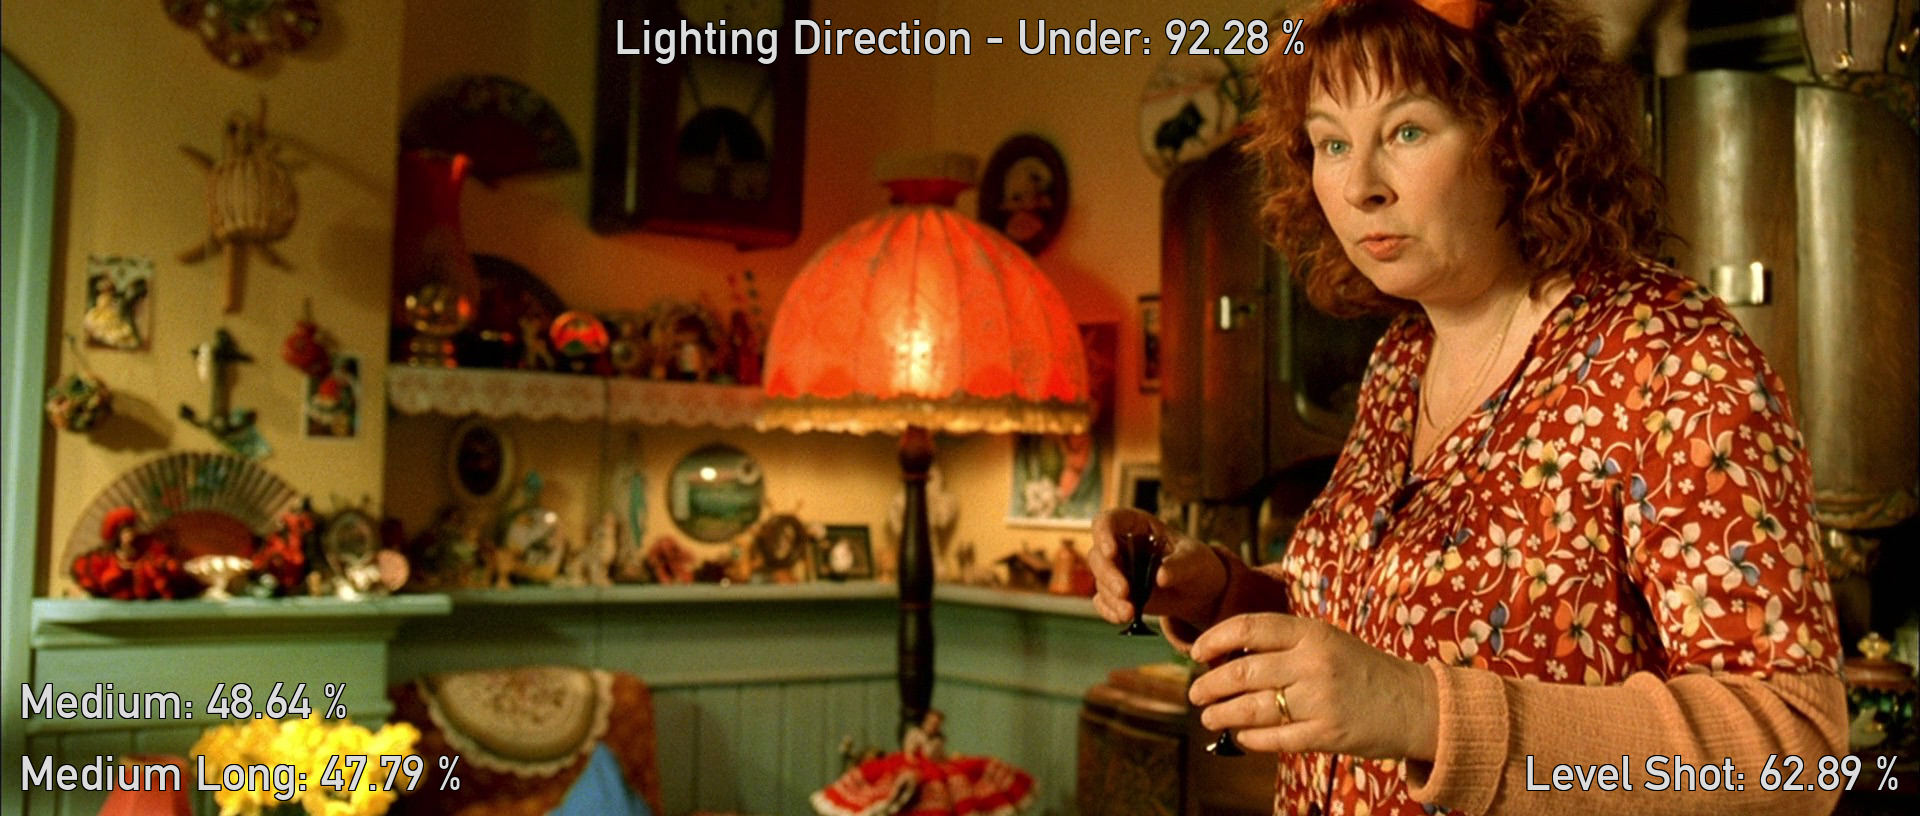

In [ ]:
f = np.random.choice(files)
preds = predict(f, None)

img = open_image(f)

img = draw(
    img    = img,
    labels = format_preds(preds['shot_angle'], top_k=1, label_formatting_dict=label_formatter),
    location = 'bottom-right')

img = draw(
    img    = img,
    labels = format_preds(preds['shot_framing'], top_k=2, label_formatting_dict=label_formatter),
    location = 'bottom-left')

img = draw(
    img    = img,
    labels = format_preds(preds['shot_lighting_direction'], top_k=1, label_formatting_dict=label_formatter),
    location = 'top')


img

In [ ]:
list(preds.keys())

['color_key',
 'color_saturation',
 'color_theory',
 'color_tones',
 'shot_angle',
 'shot_composition',
 'shot_focus',
 'shot_framing',
 'shot_level',
 'shot_lighting_cast',
 'shot_lighting_contrast',
 'shot_lighting_direction',
 'shot_lighting_silhouette',
 'shot_location',
 'shot_location_scene',
 'shot_subject',
 'shot_timeofday',
 'shot_type',
 'shot_type_overtheshoulder',
 'texture']

In [ ]:
pprint(preds)

### Predict on Video

In [ ]:
import av
import math
from tqdm.auto import tqdm
from functools import partial

def round_up(num:float) -> int: return int(math.ceil(num))
def torch_to_numpy(tensor): return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

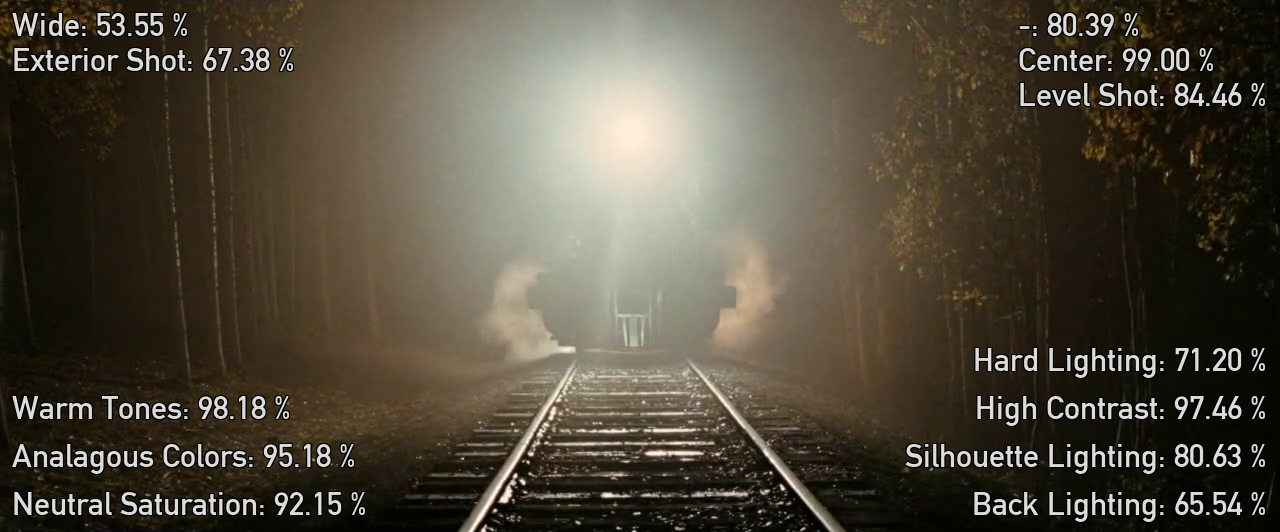

In [ ]:
pred_img

In [ ]:
PATH = '/Users/rahulsomani/Downloads/shotdeck-clips/'
output_path = '/Users/rahulsomani/Desktop/Synopsis/inference/video-tests-3_1_2/'

format_preds = partial(format_preds, label_formatting_dict=label_formatter)
draw = partial(draw, font_size=None)

video_codec   = 'libx264'
audio_codec   = 'aac'
video_pix_fmt = 'yuv420p'
output_video  = True
output_path   = output_path

prefix   = 'beta3_1_2--'
frame_stride = 5

for video_path in tqdm(Path(PATH).ls()):
    video_path = str(video_path)
    
    input_container  = av.open(video_path)
    fps = input_container.streams.video[0].average_rate

    output_fname     = str(f"{prefix}{Path(video_path).stem}-analysis.mp4")
    output_container = av.open(str(Path(output_path)/output_fname), mode='w')
    output_audio_stream = output_container.add_stream(audio_codec)
    output_video_stream = output_container.add_stream(video_codec, rate=fps)
    output_video_stream.width  = input_container.streams.video[0].width
    output_video_stream.height = input_container.streams.video[0].height

    num_frames = round_up(input_container.streams.video[0].frames)
    
    for i,frame in enumerate(tqdm(input_container.decode(video=0),
                                  total=num_frames-1 if num_frames else None)):
        img = frame.to_image()

        if i==0 or i%frame_stride==0:
            preds = predict(img, None)

        shot_preds = \
            format_preds(preds['shot_type'], top_k=1) +\
            format_preds(preds['shot_composition'], top_k=1) +\
            format_preds(preds['shot_angle'], top_k=1)
        shot_preds = ['\n'.join(shot_preds)]

        color_preds = \
            format_preds(preds['color_tones'], top_k=1)      +\
            format_preds(preds['color_theory'], top_k=1)     +\
            format_preds(preds['color_saturation'], top_k=1)

        lighting_preds = \
            format_preds(preds['shot_lighting_cast'], top_k=1) +\
            format_preds(preds['shot_lighting_contrast'], top_k=1) +\
            format_preds(preds['shot_lighting_silhouette'], top_k=1) +\
            format_preds(preds['shot_lighting_direction'], top_k=1)

        location_preds = \
            format_preds(preds['shot_framing'], top_k=1) +\
            format_preds(preds['shot_location'], top_k=1)
        location_preds = ['\n'.join(location_preds)]

        #pred_img = draw(img, location='bottom',    labels=format_preds(preds['shot_lighting_contrast'], top_k=1))
        #pred_img = draw(img, location='bottom-left',  labels=format_preds(preds['shot_lighting_cast'], top_k=1))
        #draw = partial(draw, font_size=25)
        pred_img = draw(img, location='top-left',    labels=location_preds)
        pred_img = draw(img, location='bottom-right',labels=lighting_preds)
        pred_img = draw(img, location='top-right',   labels=shot_preds)
        pred_img = draw(img, location='bottom-left', labels=color_preds)
        #break

        if output_video:
            output_frame = av.VideoFrame.from_image(pred_img)
            for packet in output_video_stream.encode(output_frame):
                output_container.mux(packet)

    # Writing Audio Frames
    input_container     = av.open(str(video_path))
    input_audio_stream  = input_container.streams.get(audio=0)[0]
    input_audio_decoder = input_container.decode(input_audio_stream)

    for frame in input_audio_decoder:
        frame.pts = None
        for packet in output_audio_stream.encode(frame):
            output_container.mux(packet)
    for packet in output_audio_stream.encode(): output_container.mux(packet)

    output_container.close()
    input_container.close()

In [ ]:
# video_path = '/Users/rahulsomani/Pictures/Edgar-Wright-How-to-Do-Visual-Comedy.webm'
# video_path = '/Users/rahulsomani/Pictures/Zack Snyder’s Justice League _ Sneak Peek _ HBO Max-lPjF9sJcj4A.mp4'
# video_path = '/Users/rahulsomani/Downloads/Edgar Wright - How to Do Visual Comedy.mp4'
# video_path = '/Users/rahulsomani/Desktop/test-videos/profiles___a_tarantino_supercut_123518521.mp4'
# video_path = '/Users/rahulsomani/Desktop/test-videos/lone_figures_155345048.mp4'
# video_path = '/Users/rahulsomani/Desktop/test-videos/loneliness_of_sofia_coppola_122354082.mp4'
# video_path = '/Users/rahulsomani/Desktop/test-videos/The Matrix - Up Close-124381641.mp4'
# video_path = '/Users/rahulsomani/Pictures/2019-Films-In-A-Minute.mp4'
# video_path = '/Users/rahulsomani/Pictures/Halt & Catch Fire Season 1 Trailer-pWrioRji60A.webm'
video_path = '/Users/rahulsomani/Downloads/shotdeck-clips/br2049-7.mp4'

assert Path(video_path).exists()

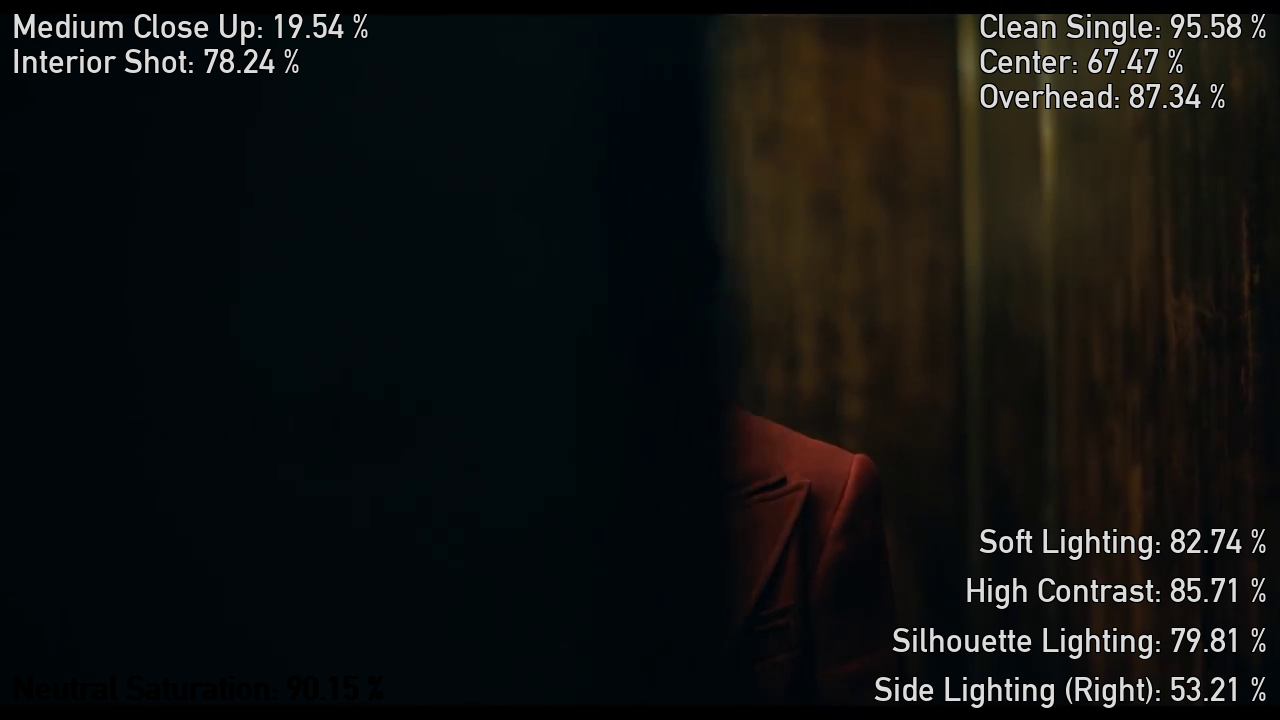

In [ ]:
pred_img

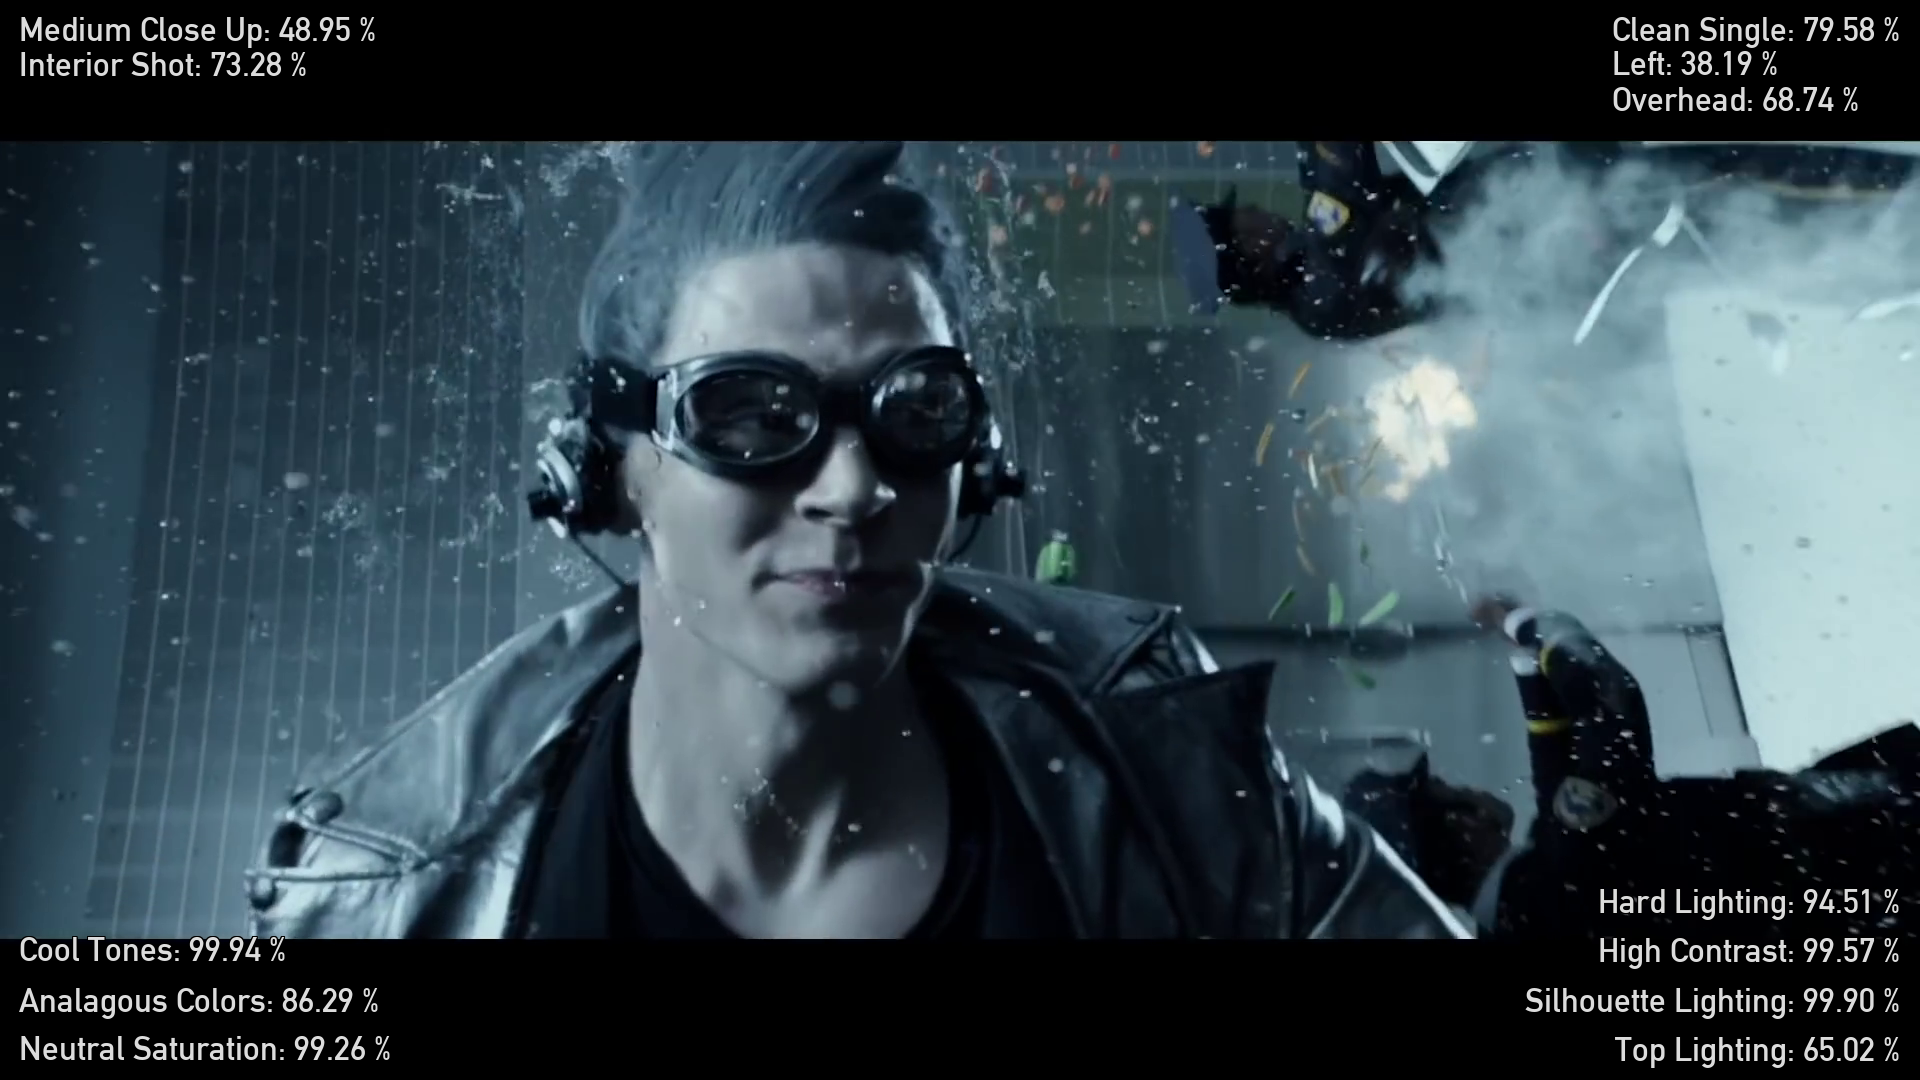

In [ ]:
pred_img

In [ ]:
import av
from functools import partial

format_preds = partial(format_preds, label_formatting_dict=label_formatter)
draw = partial(draw, font_size=33)

video_codec   = 'libx264'
audio_codec   = 'aac'
video_pix_fmt = 'yuv420p'
output_video  = True
output_path   = output_path
frame_stride  = 5

prefix   = 'beta3_1--'

#video_path = '/Users/rahulsomani/Desktop/src/2010-2019-ADecadeInFilm_Supercut-AdAl9-9TUyY.mkv'
video_path = '/Users/rahulsomani/Downloads/The Year in Movies_ 2016 Cinema Supercut.mp4'
video_path = str(video_path)

input_container  = av.open(video_path)
fps = input_container.streams.video[0].average_rate

output_fname     = str(f"{prefix}{Path(video_path).stem}-analysis.mp4")
output_container = av.open(str(Path(output_path)/output_fname), mode='w')
output_audio_stream = output_container.add_stream(audio_codec)
output_video_stream = output_container.add_stream(video_codec, rate=fps)
output_video_stream.width  = input_container.streams.video[0].width
output_video_stream.height = input_container.streams.video[0].height

num_frames = round_up(input_container.streams.video[0].frames)

for i,frame in enumerate(tqdm(input_container.decode(video=0),
                              total=num_frames-1 if num_frames else None)):
    img = frame.to_image()

    if i==0 or i%frame_stride==0:
        preds = predict(img, None)

    shot_preds = \
        format_preds(preds['shot_type'], top_k=1) +\
        format_preds(preds['shot_composition'], top_k=1) +\
        format_preds(preds['shot_angle'], top_k=1)
    shot_preds = ['\n'.join(shot_preds)]

    color_preds = \
        format_preds(preds['color_tones'], top_k=1)      +\
        format_preds(preds['color_theory'], top_k=1)     +\
        format_preds(preds['color_saturation'], top_k=1)

    lighting_preds = \
        format_preds(preds['shot_lighting_cast'], top_k=1) +\
        format_preds(preds['shot_lighting_contrast'], top_k=1) +\
        format_preds(preds['shot_lighting_silhouette'], top_k=1) +\
        format_preds(preds['shot_lighting_direction'], top_k=1)

    location_preds = \
        format_preds(preds['shot_framing'], top_k=1) +\
        format_preds(preds['shot_location'], top_k=1)
    location_preds = ['\n'.join(location_preds)]

    #pred_img = draw(img, location='bottom',    labels=format_preds(preds['shot_lighting_contrast'], top_k=1))
    #pred_img = draw(img, location='bottom-left',  labels=format_preds(preds['shot_lighting_cast'], top_k=1))
    pred_img = draw(img, location='top-left',    labels=location_preds)
    pred_img = draw(img, location='bottom-right',labels=lighting_preds)
    pred_img = draw(img, location='top-right',   labels=shot_preds)
    pred_img = draw(img, location='bottom-left', labels=color_preds)
    #break

    if output_video:
        output_frame = av.VideoFrame.from_image(pred_img)
        for packet in output_video_stream.encode(output_frame):
            output_container.mux(packet)

# Writing Audio Frames
input_container     = av.open(str(video_path))
input_audio_stream  = input_container.streams.get(audio=0)[0]
input_audio_decoder = input_container.decode(input_audio_stream)

for frame in input_audio_decoder:
    frame.pts = None
    for packet in output_audio_stream.encode(frame):
        output_container.mux(packet)
for packet in output_audio_stream.encode(): output_container.mux(packet)

output_container.close()
input_container.close()

In [ ]:
# Reading, Predicting, and Writing Video Frames
format_preds = partial(format_preds, label_formatting_dict=label_formatter)
frame_stride = 5

for i,frame in enumerate(tqdm(input_container.decode(video=0),
                              total=num_frames-1 if num_frames else None)):
    img = frame.to_image()
    
    if i==0 or i%frame_stride==0:
        preds = predict(img, None)
    
    shot_preds = \
        format_preds(preds['shot_type'], top_k=1) +\
        format_preds(preds['shot_composition'], top_k=1)
    shot_preds = ['\n'.join(shot_preds)]

    color_preds = \
        format_preds(preds['color_tones'], top_k=1)      +\
        format_preds(preds['color_theory'], top_k=1)     +\
        format_preds(preds['color_saturation'], top_k=1)

    lighting_preds = \
        format_preds(preds['shot_lighting_cast'], top_k=1) +\
        format_preds(preds['shot_lighting_contrast'], top_k=1) +\
        format_preds(preds['shot_lighting_silhouette'], top_k=1) +\
        format_preds(preds['shot_lighting_direction'], top_k=1)
    
    location_preds = \
        format_preds(preds['shot_framing'], top_k=1) +\
        format_preds(preds['shot_location'], top_k=1)
    location_preds = ['\n'.join(location_preds)]
    
    #pred_img = draw(img, location='bottom',    labels=format_preds(preds['shot_lighting_contrast'], top_k=1))
    #pred_img = draw(img, location='bottom-left',  labels=format_preds(preds['shot_lighting_cast'], top_k=1))
    draw = partial(draw, font_size=50)
    pred_img = draw(img, location='top-left',    labels=location_preds)
    pred_img = draw(img, location='bottom-right',labels=lighting_preds)
    pred_img = draw(img, location='top-right',   labels=shot_preds)
    pred_img = draw(img, location='bottom-left', labels=color_preds)
    #break
    
    if output_video:
        output_frame = av.VideoFrame.from_image(pred_img)
        for packet in output_video_stream.encode(output_frame):
            output_container.mux(packet)

# Writing Audio Frames
input_container     = av.open(str(video_path))
input_audio_stream  = input_container.streams.get(audio=0)[0]
input_audio_decoder = input_container.decode(input_audio_stream)

for frame in input_audio_decoder:
    frame.pts = None
    for packet in output_audio_stream.encode(frame):
        output_container.mux(packet)
for packet in output_audio_stream.encode(): output_container.mux(packet)

output_container.close()
input_container.close()

In [ ]:
label_formatting_dict

In [ ]:
list(taxonomy.keys())

['color_key',
 'color_saturation',
 'color_theory',
 'color_tones',
 'shot_angle',
 'shot_composition',
 'shot_focus',
 'shot_framing',
 'shot_level',
 'shot_lighting_cast',
 'shot_lighting_contrast',
 'shot_lighting_direction',
 'shot_lighting_silhouette',
 'shot_location',
 'shot_location_scene',
 'shot_subject',
 'shot_timeofday',
 'shot_type',
 'shot_type_overtheshoulder',
 'texture']

In [ ]:
list(taxonomy['shot_subject'].values())

['shot.subject.animal',
 'shot.subject.body',
 'shot.subject.face',
 'shot.subject.feet',
 'shot.subject.hands',
 'shot.subject.location',
 'shot.subject.person',
 'shot.subject.prop',
 'shot.subject.text',
 'shot.subject.vehicle',
 'shot.subject.na']

In [ ]:
label_formatter = {
    #shot timeofday
    'shot.timeofday.day': 'Daytime',
    'shot.timeofday.na':   'NA',
    'shot.timeofday.twilight': 'Twilight',
    'shot.timeofday.night': 'Night Time',
    
    #shot subject
    'shot.subject.animal': 'Subject: Animal',
    'shot.subject.body':   'Subject: Body',
    'shot.subject.face':   'Subject: Face',
    'shot.subject.feet':   'Subject: Feet',
    'shot.subject.hands':  'Subject: hands',
    'shot.subject.location': 'Subject: Location',
    'shot.subject.person': 'Subject: Person',
    'shot.subject.prop':   'Subject: Prop',
    'shot.subject.text':   'Subject: Text',
    'shot.subject.vehicle': 'Subject: Vehicle',
    'shot.subject.na':     'Subject: NA',
    
    #shot type
    'shot.type.overtheshoulder.not.overtheshoulder': 'Not OTS',
    'shot.type.overtheshoulder.overtheshoulder': 'OTS Shot',
    'shot.type.overtheshoulder.na': 'NA',
    
    #shot composition
    'shot.composition.balanced': 'Balanced Shot',
    'shot.composition.center': 'Center-Framing',
    'shot.composition.left':   'Left Heavy',
    'shot.composition.right':  'Right Heavy',
    'shot.composition.na': 'NA',
    
    #shot angle
    'shot.angle.overhead': 'Overhead Shot',
    'shot.angle.aerial':   'Aerial Shot',
    'shot.angle.high':     'High Angle',
    'shot.angle.level':    'Level Shot',
    'shot.angle.low':      'Low Angle Shot',
    'shot.angle.na':       'NA',
    
    #shot location
    'shot.location.exterior': 'Exterior Shot',
    'shot.location.interior': 'Interior Shot',
    'shot.location.na': 'NA',
    
    #OTS
    'shot.type.overtheshoulder.not.overtheshoulder': '',
    'shot.type.overtheshoulder.overtheshoulder': 'OTS Shot',
    'shot.type.overtheshoulder.na': 'NA',
    
    #silhouette lighting
    'shot.lighting.silhouette.not.silhouette': 'Not Silhouette',
    'shot.lighting.silhouette.silhouette': 'Silhouette Lighting',
    'shot.lighting.silhouette.na': 'NA',
    
    #framing
    'shot.framing.extremewide': 'Extreme Wide',
    'shot.framing.wide': 'Wide',
    'shot.framing.long': 'Long',
    'shot.framing.medium.long': 'Medium Long',
    'shot.framing.medium': 'Medium',
    'shot.framing.medium.close.up': 'Medium Close Up',
    'shot.framing.closeup.face': 'Close Up - Face',
    'shot.framing.cu.ecu.lower.body': 'Close Up - Body',
    'shot.framing.cu.ecu.prop': 'Close Up - Prop',
    'shot.framing.cu.animals.with.eyes': 'Close Up - Eyes',
    'shot.framing.extreme.close.up.eyes': 'Close Up - Eyes',
    'shot.framing.extreme.close.up.hands': 'Close Up - Hands',
    'shot.framing.extreme.close.up.mouth': 'Close Up - Mouth',
    'shot.framing.extreme.close.up.paper': 'Close Up - Paper',
    'shot.framing.na': 'NA',
    
    #angle
    'shot.angle.overhead': 'Overhead',
    'shot.angle.aerial': 'Aerial',
    'shot.angle.high': 'High Angle',
    'shot.angle.eyelevel': 'Eye Level',
    'shot.angle.low': 'Low Angle',
    'shot.angle.na': 'NA',
    
    #composition
    'shot.composition.balanced': 'Balanced',
    'shot.composition.center': 'Centered',
    'shot.composition.left': 'Left Heavy',
    'shot.composition.right': 'Right Heavy',
    'shot.composition.na': 'NA',
    
    #type
    'shot.type.cleansingle': 'Clean Single',
    'shot.type.twoshot': 'Two Shot',
    'shot.type.threeshot': 'Three Shot',
    'shot.type.group': 'Group Shot',
    'shot.type.na': 'Shot Type: NA',

    #location
    'shot.location.exterior': 'Exterior Shot',
    'shot.location.interior': 'Interior Shot',
    'shot.location.na': 'NA',
    
    #lighting direction
    'shot.lighting.direction.back': 'Back Lighting',
    'shot.lighting.direction.left': 'Side Lighting (Left)',
    'shot.lighting.direction.right': 'Side Lighting (Right)',
    'shot.lighting.direction.top': 'Top Lighting',
    'shot.lighting.direction.under': 'Lighting Direction - Under',
    'shot.lighting.direction.na': 'NA',
    
    #lighting contrast
    'shot.lighting.contrast.high': 'High Contrast',
    'shot.lighting.contrast.low':  'Low Contrast',
    'shot.lighting.contrast.na':   'NA',
    
    #color theory
    'color.theory.analagous': 'Analagous Colors',
    'color.theory.complementary': 'Complementary Colors',
    'color.theory.monochrome': 'Monochromatic Colors',
    
    #color tones
    'color.tones.blackwhite': 'Black & White Colors',
    'color.tones.cool': 'Cool Tones',
    'color.tones.warm': 'Warm Tones',
    
    #color saturation
    'color.saturation.desaturated': 'Desaturated Colors',
    'color.saturation.neutral': 'Neutral Saturation',
    'color.saturation.pastel': 'Pastel Colors',
    'color.saturation.saturated': 'Saturated Colors',
    
    #shot focus
    'shot.focus.deep': 'Deep Focus',
    'shot.focus.shallow': 'Shallow Focus',
    'shot.focus.out': 'Out of Focus',
    'shot.focus.na': 'NA',
    
    'color.key.blue': 'Blue Key',
    'color.key.green': 'Green Key',
    'color.key.luma': 'Luma Key',
    'color.key.matte': 'Matte Key',
    'color.key.shot.na': 'No Key',
    'color.key.texture.na': 'NA',
    
    #lighting cast
    'shot.lighting.cast.hard': 'Hard Lighting',
    'shot.lighting.cast.soft': 'Soft Lighting',
    'shot.lighting.cast.na':   'NA'
}

In [ ]:
list(taxonomy.keys())

['color_key',
 'color_saturation',
 'color_theory',
 'color_tones',
 'shot_angle',
 'shot_composition',
 'shot_focus',
 'shot_framing',
 'shot_level',
 'shot_lighting_cast',
 'shot_lighting_contrast',
 'shot_lighting_direction',
 'shot_lighting_silhouette',
 'shot_location',
 'shot_location_scene',
 'shot_subject',
 'shot_timeofday',
 'shot_type',
 'shot_type_overtheshoulder',
 'texture']

In [ ]:
list(taxonomy['color_key'].values())

['color.key.blue',
 'color.key.green',
 'color.key.luma',
 'color.key.matte',
 'color.key.shot.na',
 'color.key.texture.na']

## CoreML

In [ ]:
import coremltools
import os
import argparse
import csv
import PIL
from PIL import Image
import numpy

In [ ]:
model_path = '/Users/rahulsomani/Desktop/Synopsis/beta3/models_3-1/CinemaNet_3_1.mlmodel'
image_path = '/Users/rahulsomani/Downloads/test-frame.png'

model = coremltools.models.MLModel(model_path)
image = PIL.Image.open(image_path)
image = image.resize( (224,224), resample=PIL.Image.BILINEAR)

predictions = model.predict({
    'Image': image
})

In [ ]:
preds

{'color_key': {'color.key.blue': 0.0003,
  'color.key.green': 0.0001,
  'color.key.luma': 0.0636,
  'color.key.matte': 0.0087,
  'color.key.shot.na': 0.9225,
  'color.key.texture.na': 0.0049},
 'color_saturation': {'color.saturation.desaturated': 0.0453,
  'color.saturation.neutral': 0.9356,
  'color.saturation.pastel': 0.001,
  'color.saturation.saturated': 0.018},
 'color_theory': {'color.theory.analagous': 0.8844,
  'color.theory.complementary': 0.0149,
  'color.theory.monochrome': 0.1008},
 'color_tones': {'color.tones.blackwhite': 0.0068,
  'color.tones.cool': 0.1407,
  'color.tones.warm': 0.8524},
 'shot_angle': {'shot.angle.overhead': 0.0261,
  'shot.angle.aerial': 0.0045,
  'shot.angle.high': 0.0861,
  'shot.angle.eyelevel': 0.0098,
  'shot.angle.low': 0.8402,
  'shot.angle.na': 0.0333},
 'shot_composition': {'shot.composition.balanced': 0.0031,
  'shot.composition.center': 0.9619,
  'shot.composition.left': 0.0022,
  'shot.composition.right': 0.0024,
  'shot.composition.na': 0

In [ ]:
[format_preds(preds[key], top_k=1) for key in preds.keys()]

[['color.key.shot.na: 92.25 %'],
 ['color.saturation.neutral: 93.56 %'],
 ['color.theory.analagous: 88.44 %'],
 ['color.tones.warm: 85.24 %'],
 ['shot.angle.low: 84.02 %'],
 ['shot.composition.center: 96.19 %'],
 ['shot.focus.na: 75.80 %'],
 ['shot.framing.wide: 83.96 %'],
 ['shot.level.level: 97.55 %'],
 ['shot.lighting.cast.hard: 80.04 %'],
 ['shot.lighting.contrast.high: 99.82 %'],
 ['shot.lighting.direction.back: 98.05 %'],
 ['shot.lighting.silhouette.silhouette: 99.89 %'],
 ['shot.location.interior: 86.84 %'],
 ['shot.location.scene.interior.structure.building.hallway: 72.00 %'],
 ['shot.subject.location: 31.11 %'],
 ['shot.timeofday.night: 92.43 %'],
 ['shot.type.cleansingle: 74.95 %'],
 ['shot.type.overtheshoulder.not.overtheshoulder: 97.25 %'],
 ['texture.spiralled: 42.84 %']]

In [ ]:
preds

{'color_key': {'color.key.blue': 0.0003,
  'color.key.green': 0.0001,
  'color.key.luma': 0.0636,
  'color.key.matte': 0.0087,
  'color.key.shot.na': 0.9225,
  'color.key.texture.na': 0.0049},
 'color_saturation': {'color.saturation.desaturated': 0.0453,
  'color.saturation.neutral': 0.9356,
  'color.saturation.pastel': 0.001,
  'color.saturation.saturated': 0.018},
 'color_theory': {'color.theory.analagous': 0.8844,
  'color.theory.complementary': 0.0149,
  'color.theory.monochrome': 0.1008},
 'color_tones': {'color.tones.blackwhite': 0.0068,
  'color.tones.cool': 0.1407,
  'color.tones.warm': 0.8524},
 'shot_angle': {'shot.angle.overhead': 0.0261,
  'shot.angle.aerial': 0.0045,
  'shot.angle.high': 0.0861,
  'shot.angle.eyelevel': 0.0098,
  'shot.angle.low': 0.8402,
  'shot.angle.na': 0.0333},
 'shot_composition': {'shot.composition.balanced': 0.0031,
  'shot.composition.center': 0.9619,
  'shot.composition.left': 0.0022,
  'shot.composition.right': 0.0024,
  'shot.composition.na': 0

In [ ]:
for cat in sorted(predictions.keys()):
    if cat=='cinemanet_embedding': continue
    if cat=='cinemanet_probabilities': continue

In [ ]:
{cat:predictions[cat] for cat in sorted(predictions.keys()) if not cat=='cinemanet_embedding' or not cat=='cinemanet_probabilities'}

{'cinemanet_embedding': array([1.654053e-02, 0.000000e+00, 0.000000e+00, 3.698730e-02, 3.552246e-02, 3.881836e-01, 2.413330e-01, 9.002686e-03,
        4.873047e-01, 6.945801e-02, 9.173584e-02, 2.580261e-02, 4.026890e-04, 9.582520e-03, 5.096436e-02, 0.000000e+00,
        7.065430e-01, 5.249023e-01, 4.497070e-01, 2.377930e-01, 0.000000e+00, 0.000000e+00, 4.396973e-01, 6.185913e-02,
        9.231567e-03, 1.846924e-01, 2.592773e-01, 9.994507e-03, 1.254883e-01, 4.397583e-02, 1.679688e-01, 9.191895e-02,
        7.911682e-03, 0.000000e+00, 4.067993e-02, 3.799438e-02, 1.506042e-02, 1.463623e-01, 1.414795e-01, 4.697266e-01,
        2.885437e-02, 2.416611e-03, 8.712769e-03, 8.632812e-01, 5.303955e-02, 1.240845e-01, 2.081299e-01, 2.034912e-01,
        1.617432e-02, 2.805176e-01, 7.135010e-02, 4.360962e-02, 5.108643e-02, 0.000000e+00, 4.096985e-03, 1.306152e-02,
        1.465607e-02, 2.175293e-01, 8.886719e-02, 1.036835e-02, 1.250000e-01, 3.642578e-01, 5.172729e-02, 2.019043e-01,
        0.000000e